In [1]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing
import matplotlib.cm as cm
plt.style.use('seaborn')

In [2]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [35]:
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [34]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [3]:
#Downsampling
n_samples = 150000
ids_ = order_products.order_id.unique().tolist()
id_selected = random.sample(ids_,n_samples)
order_products_sr = order_products[order_products.order_id.isin(id_selected)]

In [4]:
pbu1 = order_products_sr.merge(products, on = 'product_id').sort_values(by = ['order_id','add_to_cart_order'])
pbu = pbu1.loc[:,['order_id','product_name']]
print(f'Rows: {pbu.shape[0]}')
pbu['product_name'] = pbu.product_name.str.strip().str.lower()
pbu.head()

Rows: 1514077


,order_id,product_name
0,6,cleanse
12,6,dryer sheets geranium scent
16,6,clean day lavender scent room freshener spray
18,11,teriyaki & pineapple chicken meatballs
108,11,mango pineapple salsa


In [10]:
%%time
listed_products = pbu.groupby('order_id').product_name.apply(list).reset_index()
print(f'Rows: {listed_products.shape[0]}')
listed_products.order_id = listed_products.order_id.astype(str)
listed_products.head()

Rows: 150000
Wall time: 15.3 s


,order_id,product_name
0,6,"[cleanse, dryer sheets geranium scent, clean d..."
1,11,"[teriyaki & pineapple chicken meatballs, mango..."
2,20,"[nilla wafers, mini chocolate chip waffles, sw..."
3,22,"[2% reduced fat milk, butter top white bread, ..."
4,57,"[organic baby spinach, ultra-purified water, o..."


In [11]:
%%time
#training model
tagged_products = listed_products.values.tolist()
products_by_user = [TaggedDocument(products, [order_id]) for order_id, products in tagged_products]

d2v_model = Doc2Vec(documents   = products_by_user,
                    vector_size = 30,
                    min_count   = 100,
                    workers     = 4
                   )

# comparing similarity
sample_ = str(id_selected[0])
return_3 = d2v_model.docvecs.most_similar([d2v_model[sample_]])[:4]
print(return_3)
# look into word2Vec what if the user first buys a bag of lemons what are the following recommendations

[('256998', 1.0), ('3368193', 0.8501303195953369), ('684090', 0.8463875651359558), ('630651', 0.8300687074661255)]
Wall time: 2min 4s


In [12]:
pbu1 = pbu1[['order_id','product_name']]
sample  = pbu1[pbu1.order_id == int(return_3[0][0])]
compare1 = pbu1[pbu1.order_id == int(return_3[1][0])]
compare2 = pbu1[pbu1.order_id == int(return_3[2][0])]

print('NUMBER OF ITEMS',
    '\nSample products: ',len(sample),
      '\nCompare products 1: ',len(compare1),
      '\nCompare products 2: ',len(compare2))

comp = sample.merge(compare1, on = 'product_name', how = 'outer')
comp = comp.merge(compare2, on = 'product_name', how = 'outer')
comp[['order_id_x','order_id_y','order_id','product_name']]

NUMBER OF ITEMS 
Sample products:  7 
Compare products 1:  3 
Compare products 2:  13


,order_id_x,order_id_y,order_id,product_name
0,256998.0,NaN,NaN,Organic Greek Nonfat Yogurt With Mixed Berries
1,256998.0,NaN,NaN,Organic Nonfat Greek Yogurt With Raspberries
2,256998.0,NaN,NaN,Organic Lacinato (Dinosaur) Kale
3,256998.0,NaN,NaN,Grated Parmigiano Reggiano
4,256998.0,NaN,NaN,Apple & Gouda Cheese Chicken Sausage
5,256998.0,NaN,NaN,Laundry Stain Remover
6,256998.0,NaN,NaN,Organic Strawberries
7,NaN,3368193.0,NaN,Organic Old Fashioned Rolled Oats
8,NaN,3368193.0,NaN,Total 2% All Natural Plain Greek Yogurt
9,NaN,3368193.0,NaN,Total Greek Strained Yogurt


order_numbers = [3055249, 1290423, 560921, 2985254, 816288]

## Elbow plot

In [13]:
%%time
distorsions = []
clusters = list(range(1,11))
for k in clusters:
    kmeans = KMeans(n_clusters= k, init='k-means++', max_iter=100)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    distorsions.append(kmeans.inertia_)

Wall time: 3min 10s


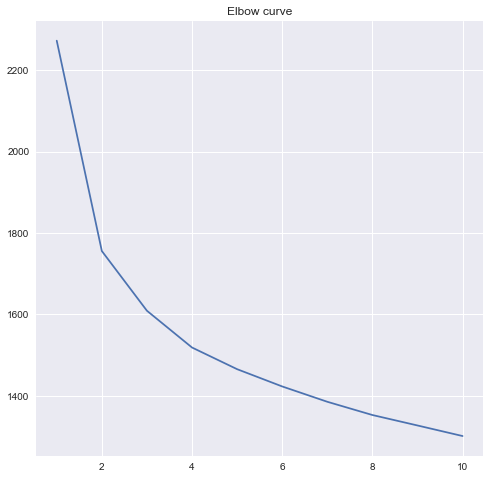

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.plot(clusters, distorsions)
plt.title('Elbow curve')
plt.show()

## Clustering

In [15]:
n_clusters_ = 3
#normalize docVecs before OR use cosine distance for KMeans
#Use DocVecs as features in stacking !!
kmeans_model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
cluster_labels = kmeans_model.labels_
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

## Representing groups

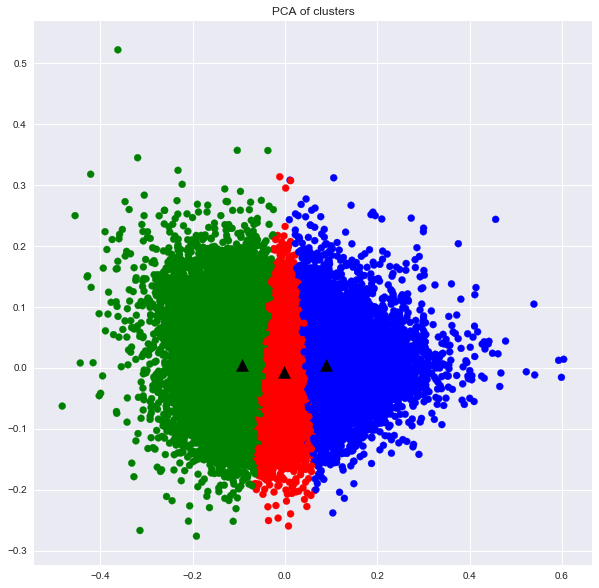

In [16]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in cluster_labels.tolist()]
plt.scatter(datapoint[:, 0], datapoint[:, 1],c = color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

## Silhouette analysis

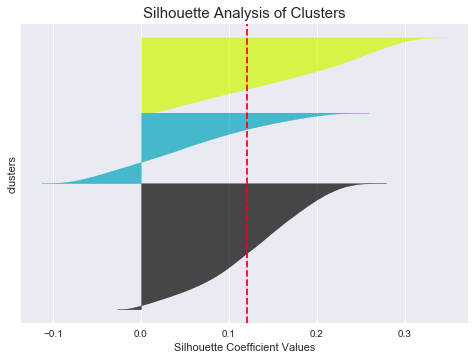

Wall time: 31min 27s


In [17]:
%%time
sample_silhouette_values = silhouette_samples(d2v_model.docvecs.vectors_docs, cluster_labels, metric='euclidean')

y_lower = 10

for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    color = cm.nipy_spectral(float(i) / n_clusters_)
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color,edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
    
silhouette_avg  = silhouette_score(d2v_model.docvecs.vectors_docs, cluster_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Analysis of Clusters', fontsize = 15)
plt.ylabel('clusters')
plt.yticks([])
plt.xlabel('Silhouette Coefficient Values')
plt.show()

# Analyzing clusters

In [18]:
listed_products['group'] = cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,order_id,product_name_x,group,product_id,add_to_cart_order,reordered,product_name_y,aisle_id,department_id
0,6,"[cleanse, dryer sheets geranium scent, clean d...",1,40462,1,0,Cleanse,31,7
1,640736,[cleanse],1,40462,1,0,Cleanse,31,7
2,1306052,[cleanse],1,40462,1,1,Cleanse,31,7
3,1384993,[cleanse],1,40462,1,1,Cleanse,31,7
4,1396139,[cleanse],1,40462,1,0,Cleanse,31,7


## cart size by group

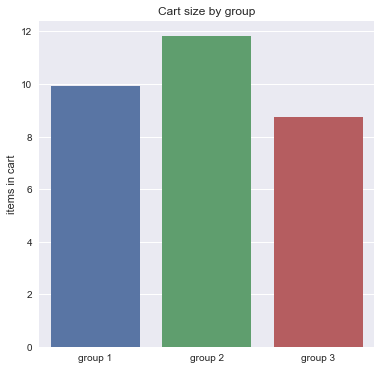

In [19]:
avg_cart_size_g1 = group_1.groupby('order_id').count().mean()[0]
avg_cart_size_g2 = group_2.groupby('order_id').count().mean()[0]
avg_cart_size_g3 = group_3.groupby('order_id').count().mean()[0]
avg_carts = [avg_cart_size_g1,avg_cart_size_g2,avg_cart_size_g3]

fig = plt.figure(figsize=(6, 6))
sns.barplot(x = ['group 1','group 2','group 3'],
            y = avg_carts)
plt.title('Cart size by group')
plt.ylabel('items in cart')
plt.show()

## Top departments for each group

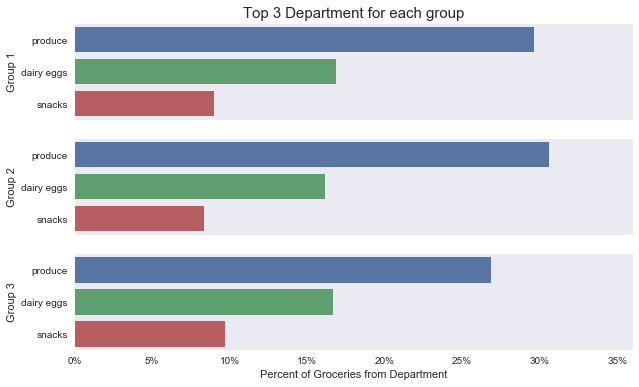

In [20]:
#group 1
t3_dept_g1_count = group_1.department_id.value_counts()[:3]/len(group_1.aisle_id)
t3_dept_g1 = departments[departments.department_id.isin(t3_dept_g1_count.index.to_list())].department

#group 2
t3_dept_g2_count = group_2.department_id.value_counts()[:3]/len(group_2.aisle_id)
t3_dept_g2 = departments[departments.department_id.isin(t3_dept_g2_count.index.to_list())].department

#group 3
t3_dept_g3_count = group_3.department_id.value_counts()[:3]/len(group_3.aisle_id)
t3_dept_g3 = departments[departments.department_id.isin(t3_dept_g3_count.index.to_list())].department

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.36
#group 1
plt.subplot(311)
plt.title('Top 3 Department for each group', fontsize = 15)
g1 = sns.barplot(x = t3_dept_g1_count.tolist(), y = t3_dept_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_dept_g2_count.tolist(), y = t3_dept_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_dept_g3_count.tolist(), y = t3_dept_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Department')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## Top Aisles for each group

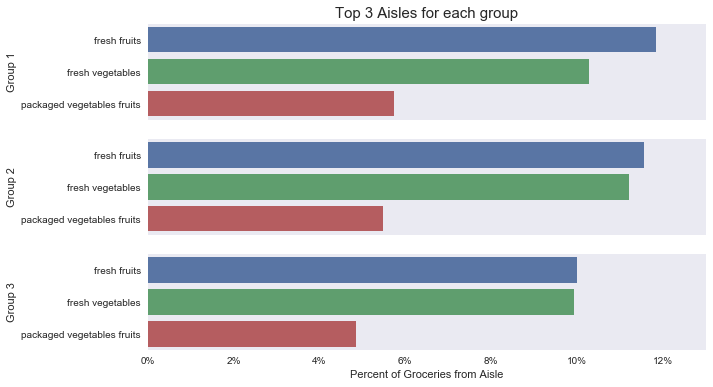

In [21]:
#group 1
t3_aisles_g1_count = group_1.aisle_id.value_counts()[:3]/len(group_1.aisle_id)
t3_aisles_g1 = aisles[aisles.aisle_id.isin(t3_aisles_g1_count.index.to_list())].aisle

#group 2
t3_aisles_g2_count = group_2.aisle_id.value_counts()[:3]/len(group_2.aisle_id)
t3_aisles_g2 = aisles[aisles.aisle_id.isin(t3_aisles_g2_count.index.to_list())].aisle

#group 3
t3_aisles_g3_count = group_3.aisle_id.value_counts()[:3]/len(group_3.aisle_id)
t3_aisles_g3 = aisles[aisles.aisle_id.isin(t3_aisles_g3_count.index.to_list())].aisle

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.13
#group 1
plt.subplot(311)
plt.title('Top 3 Aisles for each group', fontsize = 15)
g1 = sns.barplot(x = t3_aisles_g1_count.tolist(), y = t3_aisles_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_aisles_g2_count.tolist(), y = t3_aisles_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_aisles_g3_count.tolist(), y = t3_aisles_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Aisle')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## top products in each cluster

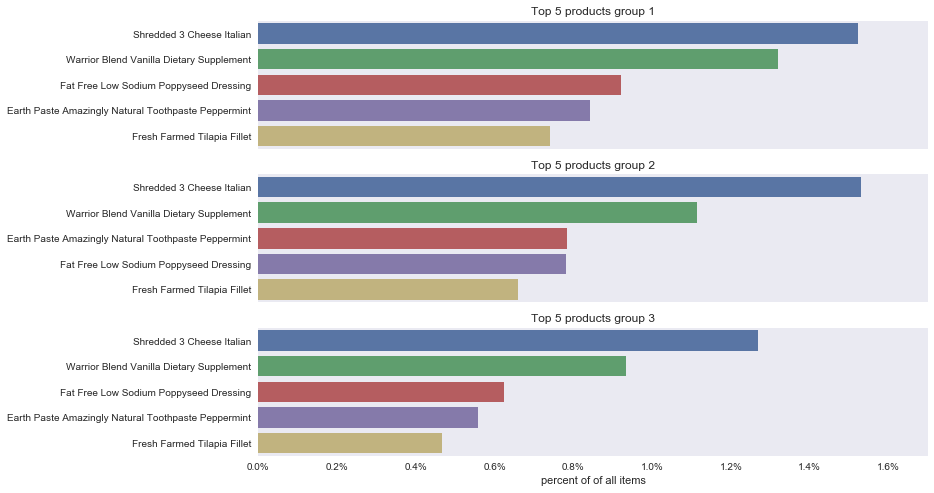

In [22]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---

## Word Vector Analysis

In [23]:
selected_ = pbu[pbu.order_id == int(tagged_products[0][0])]
selected_.head()

,order_id,product_name
0,6,cleanse
12,6,dryer sheets geranium scent
16,6,clean day lavender scent room freshener spray


In [24]:
for pn in selected_.product_name:
    try:
        print('\nSelected Word: ',pn,
              '\nWord2Vec similar words: \n',
              d2v_model.wv.most_similar(pn)[0][0],
              '\n',
              d2v_model.wv.most_similar(pn)[1][0],
              '\n',
              d2v_model.wv.most_similar(pn)[2][0]
             )
    except Exception as e:
        print('\n\n')
        print(f'word {pn} did not meet minimum threshold')
          




word cleanse did not meet minimum threshold



word dryer sheets geranium scent did not meet minimum threshold



word clean day lavender scent room freshener spray did not meet minimum threshold


In [25]:
d2v_model.wv.most_similar('organic medium salsa')

[('sweet onions', 0.7955144047737122),
 ('white onion', 0.7891324758529663),
 ('cauliflower', 0.7843789458274841),
 ('organic yellow onion', 0.7656940817832947),
 ('flat parsley, bunch', 0.7515059113502502),
 ('red onion', 0.7452954053878784),
 ('dressing, jersey sweet onion, calorie free', 0.7429490685462952),
 ('artichokes', 0.7368974685668945),
 ('fresh basil', 0.7337974309921265),
 ('green onions', 0.7334721684455872)]

In [26]:
d2v_model.wv.most_similar('yellow bell pepper')

[('orange bell pepper', 0.8672266006469727),
 ('green bell pepper', 0.8176116943359375),
 ('organic green leaf lettuce', 0.7871447205543518),
 ('organic bell pepper', 0.7805366516113281),
 ('yellow straightneck squash', 0.7799907922744751),
 ('european cucumber', 0.7778482437133789),
 ('organic fresh carrot chips', 0.7633248567581177),
 ('english seedless cucumber', 0.7593969702720642),
 ('super spinach! baby spinach, baby bok choy, sweet baby kale',
  0.7300991415977478),
 ('organic cherry tomatoes', 0.7147108316421509)]

In [27]:
d2v_model.wv.most_similar('green beans')

[('yellow straightneck squash', 0.9398972988128662),
 ('broccoli crown', 0.9202419519424438),
 ('large greenhouse tomato', 0.915311336517334),
 ('english seedless cucumber', 0.9136463403701782),
 ('russet potato', 0.9001375436782837),
 ('cauliflower', 0.8965393900871277),
 ('asparation/broccolini/baby broccoli', 0.8920684456825256),
 ('fancy eggplant', 0.890680730342865),
 ('organic bagged carrots', 0.877927839756012),
 ('yukon gold potatoes 5lb bag', 0.877260684967041)]

---

## Stacking with the vectorized model

In [33]:
vecs_df = pd.DataFrame(d2v_model.docvecs.vectors_docs)
vecs_df.columns = ['vec_' + str(col+1) for col in vecs_df.columns]
vecs_df['order_id'] = listed_products.order_id

orders = orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
stacked_df = orders.merge(vecs_df,on = 'order_id')
#stacked_df = stacked_df.drop('order_id',axis = 1)
print(f'Number of rows: {stacked_df.shape[0]} \nnumber of columns: {stacked_df.shape[1]}')
stacked_df.days_since_prior_order = stacked_df.days_since_prior_order.fillna(0)
stacked_df.head()

Number of rows: 150000 
number of columns: 35


,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,vec_1,vec_2,vec_3,vec_4,vec_5,...,vec_21,vec_22,vec_23,vec_24,vec_25,vec_26,vec_27,vec_28,vec_29,vec_30
0,2267326,3,3,18,10.0,0.007474,-0.003879,0.042417,-0.050838,0.028760,...,0.004830,0.044157,0.029741,0.004583,0.040230,0.029303,-0.022109,0.030615,-0.000971,-0.019377
1,2196797,5,0,11,6.0,-0.001356,-0.013487,0.058963,-0.011718,0.057031,...,0.011038,0.016790,0.010275,0.020644,0.045766,0.038374,-0.026919,0.017727,-0.034307,-0.015902
2,1396119,10,1,20,9.0,-0.017237,-0.014333,0.006468,0.002068,0.020576,...,0.013222,0.019428,-0.006273,0.000781,0.013489,0.011245,-0.004918,0.004502,-0.002006,-0.009106
3,369015,19,3,12,3.0,0.005018,-0.022819,0.043131,-0.040059,0.017117,...,0.019787,0.003780,0.013220,0.004791,0.038963,0.029983,-0.033235,0.029567,-0.026222,-0.007716
4,2921164,5,5,11,30.0,-0.000271,0.020317,-0.002340,0.007858,0.007101,...,0.027957,-0.021452,0.014674,0.015444,0.006773,-0.030687,0.003632,0.020380,0.030564,0.032435


In [29]:
stacked_df = pd.DataFrame(preprocessing.scale(vecs_df))
stacked_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.813231,0.418709,-0.535447,0.557717,-0.602167,0.777086,-0.284686,0.605509,1.037202,-0.146117,...,-0.525246,-0.978382,-0.436751,-0.741857,-1.234398,0.171081,-1.239928,0.150657,0.754194,-1.731358
1,0.582973,0.960574,0.404237,-0.131375,-0.771062,0.251479,-0.181624,0.184100,-0.189365,-0.336768,...,-0.998018,0.715127,0.132440,-0.050636,0.353720,-0.143367,0.037933,0.989108,-1.050107,-1.731353
2,-1.441265,0.730282,-0.558354,0.529622,-0.946917,0.328472,-0.144116,0.185212,-0.044589,-0.112578,...,0.221942,-0.633005,-0.248397,-0.853785,-0.367242,0.400912,-0.642283,0.126036,-0.642432,-1.731344
3,-0.782019,0.086962,1.039736,-0.165313,0.100283,0.006259,-0.959002,-0.666857,-1.530667,-1.489262,...,-1.305687,1.355776,0.121727,2.330000,-0.992784,-0.293955,0.041905,-0.138941,0.390962,-1.731342
4,0.872532,-0.575701,-0.006383,-1.135824,-0.174863,-0.858935,0.706758,-0.226621,-0.561398,0.228270,...,0.133390,-1.005055,1.298939,-0.417805,0.301259,-1.798381,0.388869,-1.508223,-0.591884,-1.731307


## Tree model

---